## Preference-based Policy Iteration Algorithm - Application on Inverted-Pendulum Problem

This is an attempt to replicate the work done by Fürnkranz et al., (2012) in their paper "Preference-based reinforcement learning: a formal framework and a policy iteration algorithm"

- source code of the environment can be found [here](hhttps://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py)

*TO-DOs:*
>- Run t-tests for pair-wise comparisons (only add preferences for significantly different pairs) -> might help to converge. --
>- Work with 4-dimensional state-space: but only train on 2-dimensions (pole-position and pole-velocity)


- MAIN DIFFERENCES IN MODIFIED:
    - RETRAINING THE LABEL-RANKER MODEL
    - LINEARLY ANNEALED LR

**Questions/Concerns**:
- this might only work because the starting states are close to each other
- there is no clear way how the learned policy will know which action to take at states which are not in the initial set of sampled states
- the computed reward/success graphs only are for the episodes starting from the initial set of starting states? so this doesn't learn a generalized policy?


- Performance of the policy alternates (good->bad->good): hypothesis: training dataset shrinks after following a good policy -> results with (new) bad policy -> bad policy collects more data -> results with good policy -> again less training samples..
- `LearnLabelRanker` means iteratively train the model using every new batch of training data?


**Observations**
- There is no clear mention of the exact policy derived, if we constantly pick the ranked #1 - that always gives the same result on the next roll-out. How has the authors balanced exploration vs. exploitation?
- More dense the NN becomese, more generalization happens -> high variability in the validation phrase
- when the number of training samples are low - the learned policy seems to work better (why? - should the NN overfit the training data to perform better?)

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
from IPython import display
from IPython.display import HTML

import gym
from gym import wrappers

import io
import base64
import itertools
import tqdm

from scipy.stats import rankdata as rd
from scipy import stats

    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along
        a frictionless track. The pendulum starts upright, and the goal is to
        prevent it from falling over by increasing and reducing the cart's
        velocity.
    Source:
        This environment corresponds to the version of the cart-pole problem
        described by Barto, Sutton, and Anderson
    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        Note: The amount the velocity that is reduced or increased is not
        fixed; it depends on the angle the pole is pointing. This is because
        the center of gravity of the pole increases the amount of energy needed
        to move the cart underneath it
    Reward:
        Reward is 1 for every step taken, including the termination step
    Starting State:
        All observations are assigned a uniform random value in [-0.05..0.05]
    Episode Termination:
        Pole Angle is more than 12 degrees.
        Cart Position is more than 2.4 (center of the cart reaches the edge of
        the display).
        Episode length is greater than 200.
        Solved Requirements:
        Considered solved when the average return is greater than or equal to
        195.0 over 100 consecutive trials.

In [2]:
# updating the maximum length of trajectory trajectory to 1500 steps
gym.envs.register(
    id='CartPole_PbPI_Version-v0',
    entry_point='gym.envs.classic_control:CartPoleEnv',
    max_episode_steps=1500,    
)

env = gym.make('CartPole_PbPI_Version-v0')
env.reset()

print("Number of actions: " + str(env.action_space.n))
print("Observation space: " + str(env.observation_space))
print("Max. values of observation space:" + str(env.observation_space.high))
print("Min. values of observation space:" + str(env.observation_space.low))

Number of actions: 2
Observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Max. values of observation space:[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Min. values of observation space:[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


In [3]:
# helper functions
def random_action(environment):
    """ return a random action from the given environment"""
    
    action = environment.action_space.sample()  
    return action


def generate_init_states_S(seed, env = 'CartPole_PbPI_Version-v0', filter_state=True):
    """this function returns a list of randomly generated initial states from the CartPole-v0 environment """
    
    np.random.seed(seed)
    
    n_states = np.random.randint(low=1, high=101) # how many states to generate

    init_states_S = [] # to store initial states

    env = gym.make(env)
    env.reset()

    for _ in range(n_states):

        state, reward, done, info = env.step(env.action_space.sample())  # step through the environment
        
        init_states_S.append(state)
            
        if done: # the episode ends either if the pole is > 15 deg from vertical or the cart move by > 2.4 unit from the centre
            env.reset()    
            
    env.close()
            
    return init_states_S

In [4]:
def partition_action_space(env_name:'string',n_actions:'int'):
    """function to partitions the action space of an environment into a given number of actions`"""
    
    # initialize environment
    env = gym.make(env_name)
    
    actions = np.arange(env.action_space.n)

    # a uniform noise term is added to action signals to make all state transitions non-deterministic
    part_act_space = np.linspace(actions[0],actions[-1],n_actions) + np.random.uniform(low = -.2,high=.2) 
    
    return part_act_space                                                                                

In [5]:
env_name = 'CartPole_PbPI_Version-v0'
env = gym.make(env_name)

print("Original action space: " + str(env.action_space.n))
print("Partitioned into 3 actions: " + str(partition_action_space(env_name,3)))
print("Partitioned action-space mapped to orignal action-space: " + str([int(round(action,0)) for action in partition_action_space(env_name,3)]))

Original action space: 2
Partitioned into 3 actions: [0.1320523 0.6320523 1.1320523]
Partitioned action-space mapped to orignal action-space: [0, 0, 1]


### Preference-based Approximate Policy Iteration algorithm

In [6]:
#####################################
### Evaluate-Preference procedure ###

### Functionality:
### - INPUTS  : starting state (s), two-actions(a_k, a_j), (current) policy (\pi), max. length of trajectoris (L)
### - PROCESS : generate roll-out (fixed time horizon) and calculate accumulate reward
### - OUTPUT  : compare return from each rollout: store preference info in training dataset as (s,a_k > a_j)

### - Run this procedure for every action-pair at all initial-states

def evaluate_preference(starting_state # starting state of roll-outs
                        , action_1     # first action to execute at the starting-state
                        , action_2     # second action to execute at the starting state
                        , policy_in    # policy to folow
                        , environment_name = 'CartPole_PbPI_Version-v0'   # name of the environment
                        , discount_fac = 1        # discounting factor
                        , n_rollouts = 20         # number of roll-outs to generate per action
                        , max_rollout_len = 1500  # maximum length of a roll-out
                        , label_ranker = False    # whether to use the label-ranking model or not
                        , p_sig = 0.05             # p-value to use for t-test (to compare avg. returns of roll-outs from each action)
                       ):
    
    """
    Description:
        At every state in the initial state set, roll-outs are generated by starting from each action and following the given policy.
        Accumulated rewards from each roll-out at each action are used to generate preferences for the given pair of actions.
        Preferences generated through this method are stored to create a training set to learn the label ranking model.
    
    """
    
    ### initialize local variables  ###
    
    policy = policy_in          
    n_rollouts = n_rollouts     
    gamma = discount_fac    
    s_init = starting_state
        
    actions = { 'one' : action_1    # dictionary to store input actions
              , 'two' : action_2}    

    r = { 'one' : [None]*n_rollouts # dictionary to store rewards of roll-outs, starting from each action
        , 'two' : [None]*n_rollouts}  

    avg_r = {}  # dictionary to store average discounted return for each action

    max_traj_len = max_rollout_len # maximum roll-out trajectory length    
    
    # select one action from the two given action and generate roll-outs
    for action_key, action_value in actions.items():

        for rollout in range(n_rollouts):

            env = gym.make(environment_name)
            env = env.unwrapped
            
            env.state = s_init  # set the starting state

            # pre-process the action value in case the action-space is partitioned: environment only accepts discrete action values
            action_val_processed = int(abs(round(action_value)))
            observation, reward, done, info = env.step(action_val_processed)
            
            hist = observation # store the last state (observation)
            
            r[action_key][rollout] = reward  # add the immediate reward received after executing the action

            # follow the given policy to generate a roll-out trajectory 
            # until the agent meets a terminal state or exceeds the max. trajectory length is exceeded
            traj_len = 1
            while traj_len < max_traj_len and not done: 
                
                if label_ranker: # if the policy should be derived from the label-ranking model
                    observation, reward, done, info = env.step(policy.label_ranking_policy(hist))
                    hist = observation
                    #print(f'Roll-outs generated with LabelRanker', end='\r')
                    
                else: # if the policy should be derived from a random-action selection model
                    observation, reward, done, info = env.step(policy(env))
                    #print(f'Roll-outs generated with Random policy', end='\r')

                # compute discounted-reward at each step of the roll-out and store the roll-out return
                r[action_key][rollout] += (gamma**traj_len) * reward

                traj_len += 1

            # close the environment after creating a single roll-out (and delete it)
            env.close()
            del env
            
#            print(f'roll-outs for action {action_key} complete!', end='\r')
        
        # calculate average discounted return for the two actions executed at starting state
        avg_r[action_key]  = sum(r[action_key]) / len(r[action_key])

    ### TO-DO ###
    # RUN T-TEST AND RETURN ACTION PREFERENCE ONLY IF THERE IS A SIGNIFICANT DIFFERENCE
    t_val, p_val = stats.ttest_ind(r['one'],r['two']) # unpaird t-tests: equal variance
    #print(p_val)
    
    
    # return preference info. to generate training data
    if (avg_r['one'] > avg_r['two']) and (p_val <= p_sig):
        return {'state': s_init
               , 'a_j' : actions['one']
               , 'a_k' : actions['two']
               , 'preference_label' : 1}
    
    elif(avg_r['one'] < avg_r['two']) and (p_val <= p_sig):
        return {'state': s_init
               , 'a_j' : actions['one']
               , 'a_k' : actions['two']
               , 'preference_label' : 0}
    
    else: # return NaN if avg. rewards of both actions are the same
        return {'state': np.nan
               , 'a_j' : np.nan
               , 'a_k' : np.nan
               , 'preference_label' : np.nan}
    
   

In [7]:
# test function
evaluate_preference(env.reset(),0.1,0.6,policy_in=random_action,label_ranker=False)

{'state': nan, 'a_j': nan, 'a_k': nan, 'preference_label': nan}

In [53]:
############################################
### LABEL-RANKER MODEL-TRAINING procedure ###

### Description:
###  XXX..

### Functionality:
### - INPUTS  : Xxx
### - PROCESS : Xxx
### - OUTPUT  : Xxx

### FUNCTION TO CREATE TRAINING DATASET + MODEL + RETURN THE TRAINED MODEL ###

def train_model(train_data                  # collection of all preference data
                , action_space              # action space of the task
                , model_name:str            # name for the model (to store)
                , batch_s = 4               # batch size to train the NN model
                , mod_layers = [15,7] # num. of hidden-layers (list length) and the num. of hidden units per each layer (list item value)
                , n_epochs = 300
                , l_rate = 0.01):          # num. of epochs to train the model

    ###########################################
    ###### CONSTRUCTING TRAINING-DATASET ######
        
        
    # create a training dataframe | remove rows that have np.nan -> corresponds to roll-outs with no action preference
    train_df = pd.DataFrame(train_data).dropna()

    # create a key for state | only select pole-velocity and pole-position (2-dimensions)
    train_df.loc[:, 'state_key'] = train_df.state.apply(lambda x: x[2].astype(str)+"_"+x[3].astype(str))

    # drop all states (rows) which does not include any preferred action
    temp_df1 = train_df.groupby('state_key').preference_label.sum().reset_index()
    temp_df1 = temp_df1.loc[temp_df1.preference_label>0] # pick the states that have at least one prefered action
    train_df = train_df.merge(right = temp_df1.loc[:,'state_key']
                              , right_on = 'state_key'
                              , left_on = 'state_key'
                              , how = 'right')


    ##########################################################
    ##### confirm that the training-dataset is not empty #####
    
    if train_df.shape[0]>0:
        
        # create a 'prefered-action' value for each state, action-preference pair
        train_df.loc[:,'prefered_action'] = train_df.apply(lambda row: row['a_j'] if row['preference_label'] == 1 else row['a_k']  ,axis=1)

        # compute the number of times each action is prefered at a state
        action_preference_counts = train_df.groupby('state_key').prefered_action.value_counts().unstack()
        action_preference_counts.replace(np.nan,0,inplace=True) # if an action is not preferred at a state, set it to '0'

        # remove the column index names of the `action_preference_counts' summary table
        action_preference_counts.columns.name = None

        # find actions not selected as a preferred action at any state 
        # (this is important because all actions has to be included here to create the correct target/label information for NN)
        missed_actions = [action for action in action_space if action not in action_preference_counts.columns.tolist()]
        missed_actions = np.array(missed_actions).astype(action_preference_counts.columns.dtype) # convert to the same data-type of remaining columns

        # add any missing actions to the `action_preference_counts' summary table
        if len(missed_actions)>0:

            # add the missing action (with a preference value of zero)
            for action in missed_actions:
                action_preference_counts.loc[:,action] = 0

            # sort the actions in the summary according to arrangement in action space (ascending order)
            action_preference_counts = action_preference_counts.reindex(sorted(action_preference_counts.columns), axis=1)    

        # convert the action-preference-counts of each action to a vector and add as a new column (to be used as training labels)
        #action_preference_counts.loc[:, 'preference_label_vector'] = action_preference_counts.iloc[:,0:].values.tolist()
        action_preference_counts.loc[:, 'preference_label_vector'] = pd.DataFrame({'label_data': action_preference_counts.iloc[:,0:].values.tolist()}).values

        # add preference label vector to training dataset
        train_df = train_df.merge(right = action_preference_counts.loc[:,['preference_label_vector']]
                                  , right_index= True
                                  , left_on = 'state_key'
                                  , how = 'left')

        # create the reduced training dataset (drop unnecessary columns & duplicate rows: which have data for the same state)
        train_df_reduced = train_df.loc[:,['state', 'state_key', 'preference_label_vector']]
        train_df_reduced.drop_duplicates(subset=['state_key'],inplace=True)

        print(f'Training data samples: {train_df_reduced.shape[0]}')

            
        
        ###### PREPARING TRAINING-DATA TENSORS (FOR MODEL) ######

        # normalizing the target (preference label) vectors
        output_labels_temp = np.array(train_df_reduced.preference_label_vector.tolist())
        row_sums = output_labels_temp.sum(axis=1)
        output_labels_normalized = output_labels_temp / row_sums[:, np.newaxis]

        # creating training data tensors - only get pole-velocity and pole-position
        # input_states  = torch.from_numpy(np.array(train_df_reduced.state.apply(lambda x: x.astype(float)).tolist()))
        input_states  = torch.from_numpy(np.array(train_df_reduced.state.apply(lambda x: [x[2].astype(float),x[3].astype(float)]).tolist())) # only select pole-position and pole-velocity
        output_labels = torch.from_numpy(output_labels_normalized)

        # creating TensorDataset
        train_ds = TensorDataset(input_states , output_labels)

        # defining data loader
        batch_size = batch_s
        train_dl = DataLoader(train_ds
                              , batch_size
                              , shuffle=True
                              , drop_last=True)

    # if training dataset is emtpy - return None (break the training loop)
    else:
        
        return None

    ###### CREATING NEURAL NETWORK FUNCTION APPROXIMATOR (MODEL) ######

    class Model(nn.Module):

        def __init__(self, input_state_len, output_label_len, layers, p=0.3):

            super(Model,self).__init__()

            all_layers = []
            input_size = input_state_len

            # create layers
            for layer_dim in layers:
                all_layers.append(nn.Linear(input_size, layer_dim))
                all_layers.append(nn.LeakyReLU(inplace=True))
                #all_layers.append(nn.BatchNorm1d(layer_dim))
                all_layers.append(nn.Dropout(p))
                input_size = layer_dim

            all_layers.append(nn.Linear(layers[-1], output_label_len))

            self.layers = nn.Sequential(*all_layers)

        def forward(self, state_vec):
            x = self.layers(state_vec)
            return x

        
    # define model instance
    model = Model(input_states.shape[1], output_labels.shape[1], mod_layers)

    opt = torch.optim.SGD(model.parameters(), lr = l_rate)
    loss_fn = F.mse_loss
    
    
    ###### DEFINING FIT-FUNCTION TO TRAIN THE MODEL ######

#     print('Training model...\n',end='\r')

    # to store losses
    aggregated_losses = []

    # Define a utility function to train the model
    def fit(num_epochs, model, loss_fn, opt):
        
        for epoch in range(num_epochs):
            for xb,yb in train_dl:

                # Generate predictions
                pred = model(xb.float())
                loss = loss_fn(pred, yb.float())            

                # Perform gradient descent
                loss.backward()
                opt.step()
                opt.zero_grad()

            aggregated_losses.append(loss_fn(model(input_states.float()), output_labels.float()).detach().numpy())

#             if epoch%100 == 0:
#                     print(f'epoch: {epoch:3} loss: {loss.item():10.8f}')
        print('\nTraining loss: ', loss_fn(model(input_states.float()), output_labels.float()).detach().numpy(),'\n')


    ###### TRAINING-DATA THE MODEL ######
    
    ## UNCOMMENT TO RETRAIN THE SAME NETWORK ##
    # load most recently saved model to re-train using new training data
    try:
        # path to load the model (if already saved)
        PATH = f"./models/{model_name}_pbpi_model.pt" # path
        model.load_state_dict(torch.load(PATH))
    except:
        pass

    epochs = n_epochs
    fit(epochs, model, loss_fn, opt)


    ###### SAVE MODEL (for inference) ######

    PATH = f"./models/{model_name}_pbpi_model.pt" # path
    torch.save(model.state_dict(), PATH) # save

    # plotting model loss
    plt.plot(range(epochs), aggregated_losses)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.show()

    # set the model to evaluation mode
    model.eval()

    #return the model
    return model

In [54]:
#############################
### LABEL RANKER (POLICY) ###

# This takes the trained model as an input
# When a new state is given, the model makes a prediction for each action
# This function then rank the actions based on the prediction
# I select the Highest ranked (most prefered action) 90% time and second most preferred action 10% time

class Policy():
    
    def __init__(self, action_space, model):
        self.action_space = action_space
        self.model = model
        
    def label_ranking_policy(self,obs):

        state_obs = obs[[2,3]] # only pick the 2nd and 3rd features from the state (pole-angle and angular velocity)
        state_obs = state_obs.reshape(-1,state_obs.shape[0]) # reshape to be a 2D array
        state_obs = torch.from_numpy(state_obs) # convert to a tensor

        # make the prediction for actions
        with torch.no_grad():
            preds = self.model(state_obs.float()) 

        # rank the indexes of actions (from highest ranked/preferred action to lowest)
        ranked_action_idx = (-rd(preds.detach().numpy())).argsort()[:preds.shape[1]]

        ## return the action value ##
        
        # if there are more than 2 actions
        if len(self.action_space)>2:
            remain_probs = .05/len(ranked_action_idx[2:])
            n_remain_actions = ranked_action_idx.shape[0]-2

            # - select first two (highest preferred actions) 90% and 5% of the time
            # - select one of the remaining actions 5% time
            action = np.random.choice(ranked_action_idx,1 , p=[0.9, 0.05] + list(np.repeat(remain_probs,n_remain_actions)))[0]
        
        else:
            # if there are only 2 actions
            action = np.random.choice(ranked_action_idx,1 , p=[0.95, 0.05])[0]
        
        # when action space is divided, return the correct action
        return int(abs(round(self.action_space[int(action)])))

In [55]:
def run_evaluations(policy, state_list, env_name ='CartPole_PbPI_Version-v0' ):  
    
    """function to calculate the accumulated avg. reward of roll-outs starting from a given list of states
    and following a given policy"""
    
    env_test = gym.make(env_name)
    env_test = env_test.unwrapped
    
    simu_per_state = 100
    print(f'Running evaluations...')
    
    # sufficient policy count (across all states & simulations)
    suf_policy_count = 0
    
    for state in state_list:        
        
        # generate 100 simulations from each state
        for _ in range(simu_per_state):
            
            # set the starting state
            env_test.state, obs = state, state
        
            # variable to store the return of an episode
            return_ep = 0 

            # execute 1001 steps in the environment
            for _ in range(1001):
                action = policy.label_ranking_policy(obs)
                observation, reward, done, info = env_test.step(action)
                obs = observation
                return_ep += reward
                if done: break

            env_test.reset()
            env_test.close()

            if return_ep>=100:
                suf_policy_count += 1
                
    
    return (suf_policy_count/(len(state_list)*simu_per_state))


Number of initial states: 41


Number of actions (per states): 3



Iteration 1:


Training data samples: 9

Training loss:  0.050820205 



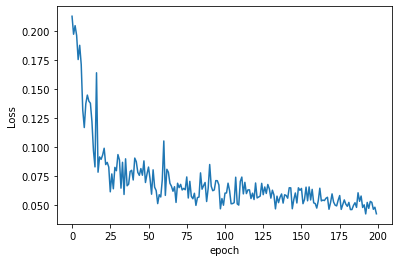

Running evaluations...


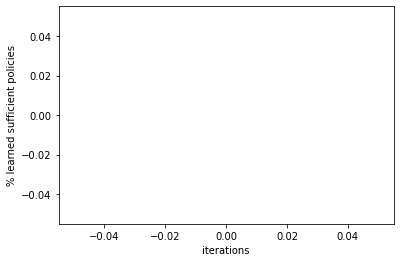

Iteration 2:


Training data samples: 4

Training loss:  0.024636177 



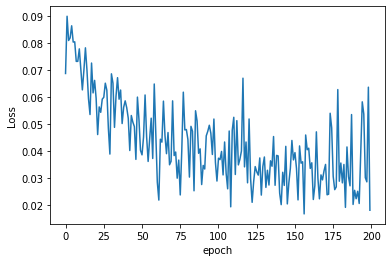

Running evaluations...


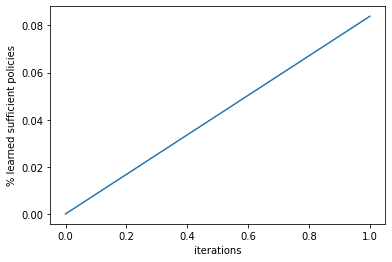

Iteration 3:


Training data samples: 25

Training loss:  0.0475268 



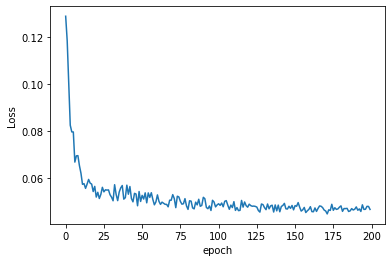

Running evaluations...


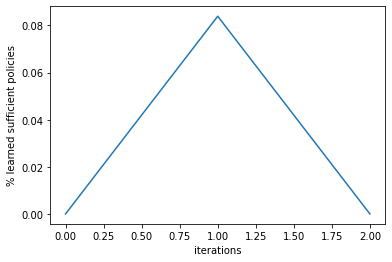

Iteration 4:


Training data samples: 2

Training loss:  0.0013362588 



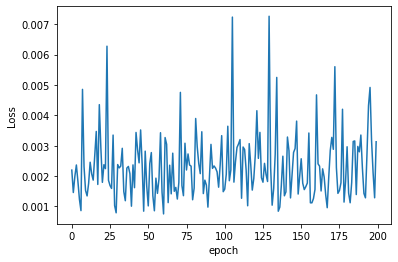

Running evaluations...


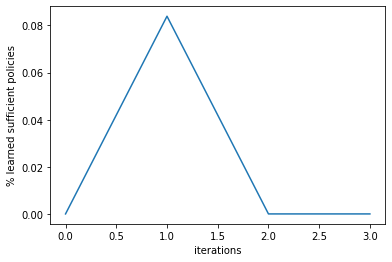

Iteration 5:


In [ ]:
###################################################
### Preference-Based Policy Iteration Algorithm ###

### Functionality:
### - INPUTS  : sample states (s'), initial (random) policy (\pi0), max. num. of policy iterations (p)
### - PROCESS : generate roll-out (fixed time horizon) and calculate accumulate reward
### - OUTPUT  : compare return from each rollout: store preference info in training dataset as (s,a_k > a_j)


# initialize environment
env = gym.make('CartPole_PbPI_Version-v0')

# sample states
seed = 2
sample_states = generate_init_states_S(seed) # randomly generated states initial

print(f'\nNumber of initial states: {len(sample_states)}\n')

# maximum number of policy iterations
max_iterr = 3000

# action space to consider
act_space = partition_action_space('CartPole_PbPI_Version-v0',3)
print(f'\nNumber of actions (per states): {len(act_space)}\n')

# generate action-pairs (per each)
act_pairs = list(itertools.combinations(act_space,2))

# initial random policy
policy_init = random_action
policy = policy_init

# store evaluation results (% of learned sufficient policies)
agg_pct_l_policies = []

# LEARNING RATES
l_rates = np.concatenate((np.linspace(0.02,0.005,1000),np.linspace(0.005,0.0001,2000)))

lr_flag = False # pass empty value for Model 

model_name = 'cartPole_modified'

# algorithm iteration loop progress
pbar = tqdm.notebook.tqdm(total=max_iterr, desc="Iteration", position = 0)

iterr = 1
while iterr < max_iterr:
    
    print(f'Iteration {iterr}:')
    
    # place-holder for training data
    train_data = [] # uncomment this after adding LabelRanker

    # state loop progress
    pbar_states = tqdm.notebook.tqdm(total=len(sample_states), desc="States", position = 1, leave=False)
    
    for state in sample_states:
        
        # action-pair loop progress
        #pbar_act_pairs = tqdm.notebook.tqdm(total=len(act_pairs), desc="action pairs", position = 2, leave=False)
        
        for action_pair in act_pairs:
            
            preference_out = evaluate_preference(starting_state = state
                                                 , action_1 = action_pair[0]
                                                 , action_2 = action_pair[1]
                                                 , policy_in = policy
                                                 , label_ranker = lr_flag
                                                 , n_rollouts = 30)   
            
            if preference_out is not None:
                train_data.append(preference_out)
            else:
                pass
                    
        # update the state loop status
        pbar_states.update(1)
    
    # process training data and learn a model
    model = train_model(train_data
                        , act_space
                        , model_name = model_name
                        , mod_layers = [10]
                        , batch_s = 4   
                        , n_epochs = 200
                        , l_rate = l_rates[iterr-1]
                        )
    
    # when no traiing data is found -> no model returned: loop continues to next iteration.
    if model is None:
        print(f'No training data collected!')
        pbar.update(1)
        iterr += 1
        continue
        
    # derive a new policy using trained model
    policy = Policy(act_space,model)
    
    # turn on inference from learnt policy
    lr_flag = True
    
    # compute the average return over all roll-outs starting at init. states by new policy
    pct_succ_policies = run_evaluations(policy, sample_states)
    agg_pct_l_policies.append(pct_succ_policies)
    
    # clear the last plot data
    plt.clf()
    plt.cla()
    plt.close()
    
    # plotting rewards over iterations
    plt.plot(range(iterr), agg_pct_l_policies)
    plt.ylabel('% learned sufficient policies')
    plt.xlabel('iterations')
    plt.savefig(f'./train_imgs/{model_name}.png') # save the evaluation image
    plt.show()
    
    
    # update the algorithm iteration loop status
    pbar.update(1)
    iterr += 1
        
pbar.close()

---
#### Test the learned policy on random starting states

In [ ]:
### Test-run for learned policy ###

# model path
PATH = "./models/cart_pole_2_states_pbpi_model.pt"

class Model(nn.Module):

        def __init__(self, input_state_len, output_label_len, layers, p=0.3):

            super(Model,self).__init__()

            all_layers = []
            input_size = input_state_len

            # create layers
            for layer_dim in layers:
                all_layers.append(nn.Linear(input_size, layer_dim))
                all_layers.append(nn.LeakyReLU(inplace=True))
                #all_layers.append(nn.BatchNorm1d(layer_dim))
                all_layers.append(nn.Dropout(p))
                input_size = layer_dim

            all_layers.append(nn.Linear(layers[-1], output_label_len))

            self.layers = nn.Sequential(*all_layers)

        def forward(self, state_vec):
            x = self.layers(state_vec)
            return x
        
# Load
model = Model(2, 3, [10])
model.load_state_dict(torch.load(PATH))
model.eval()

# create policy
policy = Policy(act_space,model)

# create environment and apply policy
env = gym.make('CartPole_PbPI_Version-v0')
env = wrappers.Monitor(env, "./gym-results", force=True)
env.reset()
for _ in range(1000):
    action = policy.label_ranking_policy(obs)
    observation, reward, done, info = env.step(action)
    obs = observation
    if done: break
env.close()

# observe policy performance
video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

---
---

## APPENDIX

---
#### 1. TRAINING DATASET PREP + MODEL + TRAINING [BREAKDOWN]

In [ ]:
# create a training dataframe
train_df = pd.DataFrame(train_data).dropna()
train_df.head(3)

In [ ]:
# create a key for state | only select pole-velocity and pole-position
train_df.loc[:, 'state_key'] = train_df.state.apply(lambda x: x[2].astype(str)+"_"+x[3].astype(str))

In [ ]:
# drop all states which does not have any preferred action
temp_df1 = train_df.groupby('state_key').preference_label.sum().reset_index()
temp_df1 = temp_df1.loc[temp_df1.preference_label>0] # pick the states that have at least one prefered action
train_df = train_df.merge(right = temp_df1.loc[:,'state_key']
                          , right_on = 'state_key'
                          , left_on = 'state_key'
                          , how = 'right')

In [ ]:
# confirm if the training dataset is not empty
train_df.shape[0]>0

In [ ]:
# create a 'prefered-action' value for each state
train_df.loc[:,'prefered_action'] = train_df.apply(lambda row: row['a_j'] if row['preference_label'] == 1 else row['a_k']  ,axis=1)

In [ ]:
train_df.head(3)

In [ ]:
# count the number of times each action (IN THE ACTION SPACE) is prefered at a state
action_preference_counts = train_df.groupby('state_key').prefered_action.value_counts().unstack()
action_preference_counts.replace(np.nan,0,inplace=True)
action_preference_counts.head()

In [ ]:
# remove the column index nameS
action_preference_counts.columns.name = None

# find actions not selected as a preferred action at any state 
missed_actions = [action for action in act_space if action not in action_preference_counts.columns.tolist()]
missed_actions = np.array(missed_actions).astype(action_preference_counts.columns.dtype) # convert to the same data-type of columns

# add any missing actions to the summary table
if len(missed_actions)>0:
    
    # add the missing action (with 0 preference value)
    for action in missed_actions:
        action_preference_counts.loc[:,action] = 0

    # sort the actions in the summary according to arrangement in action space (ascending order)
    action_preference_counts = action_preference_counts.reindex(sorted(action_preference_counts.columns), axis=1)

In [ ]:
action_preference_counts

In [ ]:
### convert the action-preference-counts to a vector (to be used as training labels)
action_preference_counts.loc[:, 'preference_label_vector'] = pd.DataFrame({'label_data': action_preference_counts.iloc[:,0:].values.tolist()}).values

In [ ]:
action_preference_counts.head()

In [ ]:
# add preference label vector to training dataset
train_df = train_df.merge(right = action_preference_counts.loc[:,['preference_label_vector']]
                          , right_index= True
                          , left_on = 'state_key'
                          , how = 'left')

In [ ]:
train_df.head(2)

In [ ]:
# create the reduced training dataset (drop unnecessary columns + duplicate rows: which have data for same state)
train_df_reduced = train_df.loc[:,['state', 'state_key', 'unique_acts', 'preference_label_vector']]

train_df_reduced.drop_duplicates(subset=['state_key'],inplace=True)
train_df_reduced.head(3)

In [ ]:
# above dataset has - state + list of actions + # preferences made for each action (at state) --> each row

In [ ]:
output_labels_temp = np.array(train_df_reduced.preference_label_vector.tolist())

# to handle 1-D output label vector
if len(output_labels_temp.shape) == 1:
    output_labels_normalized = output_labels_temp
else:
    row_sums = output_labels_temp.sum(axis=1)
    output_labels_normalized = output_labels_temp / row_sums[:, np.newaxis]

In [ ]:
# create training dataset
input_states  = torch.from_numpy(np.array(train_df_reduced.state.apply(lambda x: x.astype(float)).tolist()))
output_labels = torch.from_numpy(output_labels_normalized)

In [ ]:
# Import tensor dataset & data loader
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
train_ds = TensorDataset(input_states , output_labels )

In [ ]:
# Define data loader
batch_size = 3
train_dl = DataLoader(train_ds, batch_size, shuffle=True, drop_last=True)
next(iter(train_dl))

In [ ]:
class Model(nn.Module):

    def __init__(self, input_state_len, output_label_len, layers, p=0.4):
        
        super().__init__()
        self.batch_norm_num = nn.BatchNorm1d(input_state_len)

        all_layers = []
        input_size = input_state_len

        # create layers
        for layer_dim in layers:
            all_layers.append(nn.Linear(input_size, layer_dim))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(layer_dim))
            all_layers.append(nn.Dropout(p))
            input_size = layer_dim

        all_layers.append(nn.Linear(layers[-1], output_label_len))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, state_vec):
        x = self.batch_norm_num(state_vec)
        x = self.layers(x)
        return x

In [ ]:
# Define model
model = Model(input_states.shape[1], output_labels.shape[1], [100,500,50], p=0.4)
# model = Model(input_states.shape[1], 1 if len(output_labels.shape)== 1 else output_labels.shape[1], [100,500,50], p=0.4) # for 1-D targets


In [ ]:
model

In [ ]:
opt = torch.optim.SGD(model.parameters(), lr = 1e-1)
loss_fn = F.mse_loss

In [ ]:
# to store losses
aggregated_losses = []

# Define a utility function to train the model
def fit(num_epochs, model, loss_fn, opt):
    
    for epoch in range(num_epochs):
        for xb,yb in train_dl:
            
            # Generate predictions
            pred = model(xb.float())
            #loss = loss_fn(pred, yb.float())            
            loss = loss_fn(pred, yb.reshape(3,1).float()) 
            
            # Perform gradient descent
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        #aggregated_losses.append(loss_fn(model(input_states.float()), output_labels.float()).detach().numpy())
        
        if epoch%25 == 0:
                print(f'epoch: {epoch:3} loss: {loss.item():10.8f}')
            
    print('Training loss: ', loss_fn(model(input_states.float()), output_labels.float()))

In [ ]:
xb,yb = next(iter(train_dl))
pred = model(xb.float())
#loss_fn(pred, yb.float())  
yb.reshape(3,1).float()

In [ ]:
epochs= 300
fit(epochs, model, loss_fn, opt)

In [ ]:
plt.plot(range(epochs), aggregated_losses)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

---

#### Label Ranking Policy

In [ ]:
env = gym.make('CartPole-v0')
observation = env.reset()

state_obs = observation[[2,3]] # only select angel and angular velo. of pendulum from state vector
state_obs = state_obs.reshape(-1,state_obs.shape[0]) # reshape to be a 2D array
state_obs = torch.from_numpy(state_obs) # convert to a tensor

# make the prediction for actions
with torch.no_grad():
    preds = model(state_obs.float()) 
    
# rank the indexes of actions (from highest ranked/preferred action to lowest)
ranked_action_idx = (-rd(preds.detach().numpy())).argsort()[:preds.shape[1]]

# return the action value
remain_probs = .1/len(ranked_action_idx[2:])
n_remain_actions = ranked_action_idx.shape[0]-2

# - select first two (highest preferred actions) 80% and 10% of the time
# - select one of the remaining actions 10% time
action = np.random.choice(ranked_action_idx,1 , p=[0.8, 0.1] + list(np.repeat(remain_probs,n_remain_actions)))[0]

action

---

### Visualize episode

##### METHOD 1:

In [ ]:
env = gym.make('MountainCar_PbPI_Version-v0')
env = wrappers.Monitor(env, "./gym-results/mount-car", force=True)
env.reset()
for _ in range(1000):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(random_action(env))
    if done: break
env.close()

video = io.open('./gym-results/mount-car/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

##### METHOD 2:

In [ ]:
nb_episodes = 20
nb_timesteps = 100
img = plt.imshow(env.render(mode='rgb_array')) # only call this once

for episode in range(nb_episodes):  # iterate over the episodes
    state = env.reset()             # initialise the environment
    rewards = []
    
    for t in range(nb_timesteps):    # iterate over time steps
        #env.render()                 # display the environment
        img.set_data(env.render(mode='rgb_array')) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, info = env.step(0)  # implement the action chosen by the policy
        rewards.append(reward)      # add 1 to the rewards list
        
        if done: # the episode ends either if the pole is > 15 deg from vertical or the cart move by > 2.4 unit from the centre
            cumulative_reward = sum(rewards)
            print("episode {} finished after {} timesteps. Total reward: {}".format(episode, t+1, cumulative_reward))  
            break
    
env.close()

---

##### OTHER USEFUL-INFO: